In [1]:
import functools
import pandas as pd
from time import perf_counter
from kooplearn.datasets import LogisticMap
from kooplearn.models import KernelDMD
from kooplearn.data import traj_to_contexts
from kooplearn._src.utils import topk
from kooplearn._src.metrics import directed_hausdorff_distance
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.model_selection import ParameterGrid
from scipy.spatial.distance import pdist
from tqdm.notebook import tqdm
import numpy as np
import ml_confs
from sklearn.utils import resample
import matplotlib.pyplot as plt  

configs_dict = {
    'N': 20,
    'num_train': 20000, 
    'num_val': 1000,
    'num_test': 10000,
    'rank': 10,
}

configs = ml_confs.from_dict(configs_dict, register_jax_pytree=False)

# Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

In [2]:
logistic = LogisticMap(N=configs.N, rng_seed=0)
# Data pipeline
sample_traj = logistic.sample(
    0.5, configs.num_train + configs.num_val + configs.num_test
)

dataset = {
    "train": sample_traj[: configs.num_train],
    "validation": sample_traj[configs.num_train : configs.num_train + configs.num_val],
    "test": sample_traj[configs.num_train + configs.num_val :],
}

ref_eigs = logistic.eig()
top_eigs = topk(np.abs(ref_eigs), 3)
ref_eigs = ref_eigs[top_eigs.indices]

In [4]:
len(sample_traj)

31001

In [5]:
# train_traj = resample(dataset['train'], replace=False, n_samples=1000, random_state=0)
train_traj = dataset['train'][:10000]
train_ctx = traj_to_contexts(train_traj)
test_ctx = traj_to_contexts(dataset['test'])
val_ctx = traj_to_contexts(dataset['validation'])

In [5]:
dataset['test'].shape

(10001, 1)

In [6]:
num_ls = 5
ls_quantiles = np.linspace(0.05, 0.95, num_ls)
ls_grid = np.quantile(pdist(train_traj), ls_quantiles)
reg_grid = np.logspace(-5, 0, 6)
hp_grid = ParameterGrid({'ls': ls_grid, 'reg': reg_grid})

In [3]:
def R4_repeated_runs(n_rep):
    risks = []
    timings = []
    eigs = []
    Hdist = []
    for r in tqdm(np.arange(n_rep),total=n_rep,desc='R4 repetitions'):
        model = KernelDMD(kernel = kernel, rank = configs.rank, tikhonov_reg = reg, svd_solver='randomized', n_oversamples=20, rng_seed=r)
        timed_fit = timer(model.fit)
        model, fit_time = timed_fit(train_ctx, verbose=False)
        timings.append(fit_time)
        risks.append(model.risk(test_ctx))
        all_eigs = model.eig()
        top_eigs = topk(np.abs(all_eigs), 3)
        eigs.append(all_eigs[top_eigs.indices])
        Hdist.append(directed_hausdorff_distance(eigs[-1], ref_eigs))
    return risks, eigs, Hdist, timings
    
    
def train_and_eval(ls, reg, kernel, svd_solver, n_oversamples = 20, rank = configs.rank, rng_seed = 0):
    kernel = kernel(length_scale=ls)
    model = KernelDMD(kernel = kernel, rank = rank, tikhonov_reg = reg, svd_solver=svd_solver, n_oversamples=n_oversamples, rng_seed=rng_seed)
    timed_fit = timer(model.fit)
    model, fit_time = timed_fit(train_ctx, verbose=False)
    val_risk = model.risk(val_ctx)
    return model, val_risk, fit_time

def grid_search(hp_grid, svd_solver):
    best_risk = np.inf
    best_vals = None
    best_model = None
    
    timings = []
    risks = []
    kernel = RBF

    for hp in tqdm(hp_grid, total=len(hp_grid), desc='HP tuning'):
        model, val_risk, fit_time = train_and_eval(hp['ls'], hp['reg'], kernel, svd_solver)
        timings.append(fit_time)
        risks.append(val_risk)
        if val_risk < best_risk:
            best_risk = val_risk
            best_vals = hp
            best_model = model
            
    return best_risk, best_vals, best_model, timings

In [ ]:
best_risk = np.inf
best_vals = None
best_model = None

timings = []
risks = []
hp_params = list(hp_grid)
kernel = RBF

for hp in tqdm(hp_grid, total=len(hp_grid), desc='HP tuning'):
    model, val_risk, fit_time = train_and_eval(hp['ls'], hp['reg'], kernel, 'arnoldi')
    timings.append(fit_time)
    risks.append(val_risk)
    if val_risk < best_risk:
        best_risk = val_risk
        best_vals = hp
        best_model = model

HP tuning:   0%|          | 0/30 [00:00<?, ?it/s]

In [10]:
best_vals

{'ls': 0.8537483774560708, 'reg': 1e-05}

In [49]:
ls = best_vals['ls']
reg = best_vals['reg']
kernel = RBF(length_scale=ls)

R3 = KernelDMD(kernel = kernel, rank = configs.rank, tikhonov_reg = reg, svd_solver='arnoldi')
R4 = KernelDMD(kernel = kernel, rank = configs.rank, tikhonov_reg = reg, svd_solver='randomized', n_oversamples=20, rng_seed=0)
R4GT = KernelDMD(kernel = kernel, rank = configs.rank, tikhonov_reg = reg, svd_solver='randomized', n_oversamples=20, rng_seed=0, GT=True)

In [50]:
R3 = R3.fit(train_ctx)

Fitted KernelDMD model. Lookback length set to 1


In [51]:
R4 = R4.fit(train_ctx)

Fitted KernelDMD model. Lookback length set to 1


In [52]:
R4GT = R4GT.fit(train_ctx)

Fitted KernelDMD model. Lookback length set to 1


In [53]:
R4_repeated_runs(5)

R4 repetitions:   0%|          | 0/5 [00:00<?, ?it/s]

([0.08026345960536618,
  0.08076118843840319,
  0.08069247479225139,
  0.08082402292817792,
  0.08063331192441137],
 [array([ 0.99955041+0.j, -0.27717513+0.j, -0.0693562 +0.j]),
  array([ 1.00028516+0.j, -0.27175608+0.j, -0.07070845+0.j]),
  array([ 1.00006714+0.j, -0.2767515 +0.j, -0.06945373+0.j]),
  array([ 1.00036533+0.j, -0.27394012+0.j, -0.0701435 +0.j]),
  array([ 0.99998325+0.j, -0.2755586 +0.j, -0.06975979+0.j])],
 [0.22766363947402637,
  0.226930059747629,
  0.22761053881981133,
  0.2272358481673601,
  0.2274441011298199],
 [0.07017236202955246,
  0.05872804799582809,
  0.05820011696778238,
  0.05857580900192261,
  0.05808850796893239])

In [54]:
R3.risk()

0.0802918093385343

In [55]:
R4.risk()

0.07991808093113861

In [56]:
R4GT.risk()

0.08010316238734771

In [57]:
R3_eigs = R3.eig()
top_eigs = topk(np.abs(R3_eigs), 3)
R3_eigs = R3_eigs[top_eigs.indices]

R4_eigs = R4.eig()
top_eigs = topk(np.abs(R4_eigs), 3)
R4_eigs = R4_eigs[top_eigs.indices]

In [58]:
R3_hausdorff = directed_hausdorff_distance(R3_eigs, ref_eigs)
R4_hausdorff = directed_hausdorff_distance(R4_eigs, ref_eigs)

In [59]:
R3_hausdorff

0.22745502792606215

In [60]:
R4_hausdorff

0.22766363947402637

In [44]:
def R4_repeated_runs(n_rep, GT):
    risks_train = []
    risks_test = []
    timings = []
    eigs = []
    Hdist = []        
    model = KernelDMD(kernel = kernel, rank = configs.rank, tikhonov_reg = reg, svd_solver='randomized', n_oversamples=20, GT=GT)
    for r in tqdm(np.arange(n_rep),total=n_rep,desc='R4 repetitions'):
        model.rng_seed = r
        timed_fit = timer(model.fit)
        model, fit_time = timed_fit(train_ctx, verbose=False)
        timings.append(fit_time)
        risks_train.append(model.risk())
        risks_test.append(model.risk(test_ctx))
        all_eigs = model.eig()
        all_svals = model.svals()
        top_eigs = topk(np.abs(all_eigs), 3)
        eigs.append(all_eigs[top_eigs.indices])
        Hdist.append(directed_hausdorff_distance(eigs[-1], ref_eigs))
    return risks_train, risks_test, eigs, all_svals, Hdist, timings

In [23]:
np.logspace(-9, -3, 13)

array([1.00000000e-09, 3.16227766e-09, 1.00000000e-08, 3.16227766e-08,
       1.00000000e-07, 3.16227766e-07, 1.00000000e-06, 3.16227766e-06,
       1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03])

In [33]:
# n_training_samples = [500, 1000, 2000, 5000, 10000]
n_training_samples = [200, 500, 1000, 2000, 5000]

test_ctx = traj_to_contexts(dataset['test'])
val_ctx = traj_to_contexts(dataset['validation'])

R3_risk_test = []
R4_risk_test = []

R3_risk_train = []
R4_risk_train = []

R3_time = []
R4_time = []

R3_Hdist = []
R4_Hdist = []

R3_eigs = []
R4_eigs = []

R4GT_risk_test = []
R4GT_risk_train = []
R4GT_eigs = []
R4GT_Hdist = []
R4GT_time = []

for n in n_training_samples:
    print('Training Sample size: ', n)
    train_traj = dataset['train'][:n]
    train_ctx = traj_to_contexts(train_traj)
    
    num_ls = 11
    ls_quantiles = np.linspace(0.05, 0.95, num_ls)
    ls_grid = np.quantile(pdist(train_traj), ls_quantiles)
    reg_grid = np.logspace(-6, -3, 7)
    reg_grid = [1e-3]
    hp_grid = ParameterGrid({'ls': ls_grid, 'reg': reg_grid})
    
    best_risk, best_vals, best_model, _ = grid_search(hp_grid, 'arnoldi')
    print(best_risk, best_vals)
    ls = best_vals['ls']
    reg = best_vals['reg']
    kernel = RBF(length_scale=ls)
    
    R3 = KernelDMD(kernel = kernel, rank = configs.rank, tikhonov_reg = reg, svd_solver='arnoldi')
    # R4 = KernelDMD(kernel = kernel, rank = configs.rank, tikhonov_reg = reg, svd_solver='randomized', n_oversamples=20, rng_seed=0)
    
    timed_fit = timer(R3.fit)
    R3, fit_time_R3 = timed_fit(train_ctx)
    R3_risk_train.append(R3.risk())
    R3_risk_test.append(R3.risk(test_ctx))
    R3_time.append(fit_time_R3)
    eigs = R3.eig()
    top_eigs = topk(np.abs(eigs), 3)
    R3_eigs.append(eigs[top_eigs.indices])
    R3_Hdist.append(directed_hausdorff_distance(R3_eigs[-1], ref_eigs))

    # try:
    risks_train, risks_test, eigs, Hdists, timings = R4_repeated_runs(10, False)
    R4_risk_train.append(risks_train)
    R4_risk_test.append(risks_test)
    R4_eigs.append(eigs)
    R4_Hdist.append(Hdists)
    R4_time.append(timings)
    # except:
    # R4_risk_train.append(None)
    # R4_risk_test.append(None)
    # R4_eigs.append(None)
    # R4_Hdist.append(None)
    # R4_time.append(None)
    
    risks_train, risks_test, eigs, Hdists, timings = R4_repeated_runs(10, True)
    R4GT_risk_train.append(risks_train)
    R4GT_risk_test.append(risks_test)
    R4GT_eigs.append(eigs)
    R4GT_Hdist.append(Hdists)
    R4GT_time.append(timings)

Training Sample size:  200


HP tuning:   0%|          | 0/11 [00:00<?, ?it/s]

The computed projector is not real. The Kernel matrix is severely ill-conditioned.
The computed projector is not real. The Kernel matrix is severely ill-conditioned.
The numerical rank of the projector is smaller than the selected rank (10). 3 degrees of freedom will be ignored.


0.09015025670728483 {'ls': 0.847829745623151, 'reg': 0.001}
Fitted KernelDMD model. Lookback length set to 1


/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:382: RuntimeWarning: divide by zero encountered in reciprocal
  r_normr = np.where(norm_r == 0.0, 0.0, norm_r**-1)
/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:387: RuntimeWarning: divide by zero encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


R4 repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:387: RuntimeWarning: invalid value encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


R4 repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Training Sample size:  500


HP tuning:   0%|          | 0/11 [00:00<?, ?it/s]

The computed projector is not real. The Kernel matrix is severely ill-conditioned.
The numerical rank of the projector is smaller than the selected rank (10). 3 degrees of freedom will be ignored.


0.08142244921018094 {'ls': 0.8674405381951485, 'reg': 0.001}
Fitted KernelDMD model. Lookback length set to 1


/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:382: RuntimeWarning: divide by zero encountered in reciprocal
  r_normr = np.where(norm_r == 0.0, 0.0, norm_r**-1)
/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:387: RuntimeWarning: divide by zero encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


R4 repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:387: RuntimeWarning: invalid value encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


R4 repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Training Sample size:  1000


HP tuning:   0%|          | 0/11 [00:00<?, ?it/s]

The computed projector is not real. The Kernel matrix is severely ill-conditioned.


0.07932984123568587 {'ls': 0.8620697073530256, 'reg': 0.001}


The computed projector is not real. The Kernel matrix is severely ill-conditioned.
The numerical rank of the projector is smaller than the selected rank (10). 3 degrees of freedom will be ignored.


Fitted KernelDMD model. Lookback length set to 1


/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:382: RuntimeWarning: divide by zero encountered in reciprocal
  r_normr = np.where(norm_r == 0.0, 0.0, norm_r**-1)
/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:387: RuntimeWarning: divide by zero encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


R4 repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:387: RuntimeWarning: invalid value encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


R4 repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Training Sample size:  2000


HP tuning:   0%|          | 0/11 [00:00<?, ?it/s]

0.0801805707690515 {'ls': 0.8540060927606115, 'reg': 0.001}


The computed projector is not real. The Kernel matrix is severely ill-conditioned.
The numerical rank of the projector is smaller than the selected rank (10). 3 degrees of freedom will be ignored.


Fitted KernelDMD model. Lookback length set to 1


/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:382: RuntimeWarning: divide by zero encountered in reciprocal
  r_normr = np.where(norm_r == 0.0, 0.0, norm_r**-1)
/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:387: RuntimeWarning: invalid value encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


R4 repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:387: RuntimeWarning: divide by zero encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


R4 repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Training Sample size:  5000


HP tuning:   0%|          | 0/11 [00:00<?, ?it/s]

The computed projector is not real. The Kernel matrix is severely ill-conditioned.


0.08074637992906397 {'ls': 0.8517507499555689, 'reg': 0.001}


The computed projector is not real. The Kernel matrix is severely ill-conditioned.
The numerical rank of the projector is smaller than the selected rank (10). 4 degrees of freedom will be ignored.


Fitted KernelDMD model. Lookback length set to 1


/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:382: RuntimeWarning: divide by zero encountered in reciprocal
  r_normr = np.where(norm_r == 0.0, 0.0, norm_r**-1)
/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:387: RuntimeWarning: divide by zero encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


R4 repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:387: RuntimeWarning: invalid value encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


R4 repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
dict = {
    'n_training_samples': n_training_samples,
    'R3_risk_train': R3_risk_train,
    'R3_risk_test': R3_risk_test,
    'R4_risk_train': R4_risk_train,
    'R4_risk_test': R4_risk_test,
    'R4GT_risk_train': R4GT_risk_train,
    'R4GT_risk_test': R4GT_risk_test,
    'R3_time': R3_time,
    'R4_time': R4_time,
    'R4GT_time': R4GT_time,
    'R3_Hdist': R3_Hdist,
    'R4_Hdist': R4_Hdist,
    'R4GT_Hdist': R4GT_Hdist,
    'R3_eigs': R3_eigs,
    'R4_eigs': R4_eigs,
    'R4GT_eigs': R4GT_eigs,
}

results = pd.DataFrame(dict)
results.to_pickle('results/logistic_map/logistic_map_results_1e-3_r10.pkl')

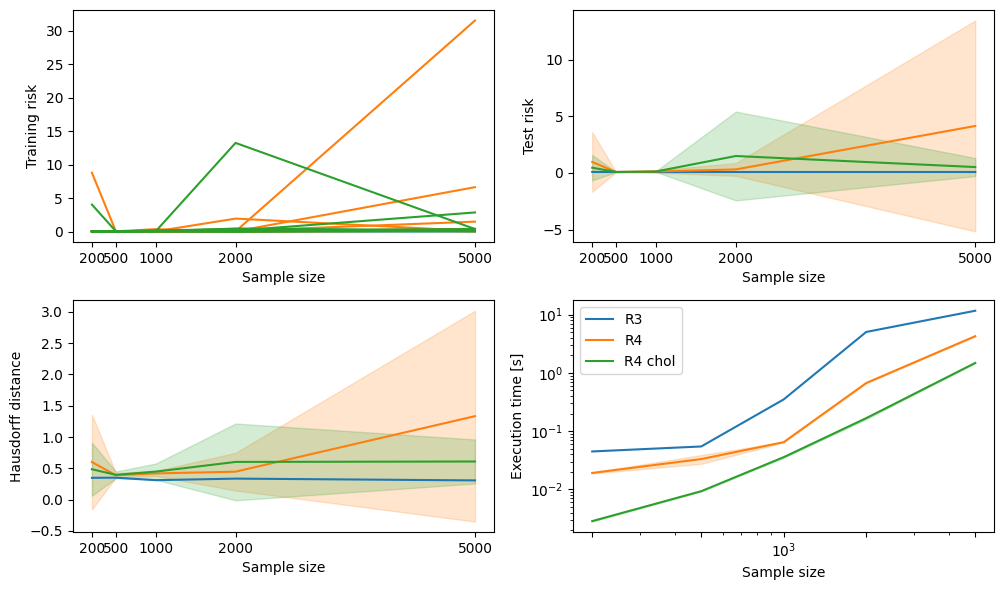

In [43]:
results = pd.read_pickle("results/logistic_map/logistic_map_results_1e-3_r10.pkl")
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

n = results['n_training_samples']

fig_width = 10 #Inches
fig_height = 6 #Inches

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(fig_width, fig_height))
axes = axes.flatten()

ax = axes[0]
ax.plot(n, results.R3_risk_train, color=cycle[0])

R4_avg = results.R4_risk_train.apply(np.mean)
# R4_avg = results.R4_risk_train.apply(np.min)
R4_std = results.R4_risk_train.apply(np.std)
# ax.plot(n, R4_avg, color=cycle[1])
# ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[1], alpha=0.2)
ax.plot(n, np.stack(results.R4_risk_train), color=cycle[1])

R4_avg = results.R4GT_risk_train.apply(np.mean)
# R4_avg = results.R4GT_risk_train.apply(np.min)
R4_std = results.R4GT_risk_train.apply(np.std)
# ax.plot(n, R4_avg, color=cycle[2])
ax.plot(n, np.stack(results.R4GT_risk_train), color=cycle[2])
# ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[2], alpha=0.2)
ax.set_xlabel('Sample size') 
ax.set_ylabel('Training risk') 

ax = axes[1]
ax.plot(n, results.R3_risk_test, color=cycle[0])
R4_avg = results.R4_risk_test.apply(np.mean)
R4_std = results.R4_risk_test.apply(np.std)
ax.plot(n, R4_avg, color=cycle[1])
ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[1], alpha=0.2)
R4_avg = results.R4GT_risk_test.apply(np.mean)
R4_std = results.R4GT_risk_test.apply(np.std)
ax.plot(n, R4_avg, color=cycle[2])
ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[2], alpha=0.2)
ax.set_xlabel('Sample size') 
ax.set_ylabel('Test risk') 

ax = axes[2]
ax.plot(n, results.R3_Hdist, color=cycle[0])
R4_avg = results.R4_Hdist.apply(np.mean)
R4_std = results.R4_Hdist.apply(np.std)
ax.plot(n, R4_avg, color=cycle[1])
ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[1], alpha=0.2)
R4_avg = results.R4GT_Hdist.apply(np.mean)
R4_std = results.R4GT_Hdist.apply(np.std)
ax.plot(n, R4_avg, color=cycle[2])
ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[2], alpha=0.2)
ax.set_xlabel('Sample size') 
ax.set_ylabel('Hausdorff distance') 

ax = axes[3]
ax.plot(n, results.R3_time, color=cycle[0], label = 'R3')
R4_avg = results.R4_time.apply(np.mean)
R4_std = results.R4_time.apply(np.std)
ax.plot(n, R4_avg, color=cycle[1], label = 'R4')
ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[1], alpha=0.2)
R4_avg = results.R4GT_time.apply(np.mean)
R4_std = results.R4GT_time.apply(np.std)
ax.plot(n, R4_avg, color=cycle[2], label = 'R4 chol')
ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[2], alpha=0.2)
ax.legend()
ax.set_xlabel('Sample size') 
ax.set_ylabel('Execution time [s]') 
ax.set_yscale('log')
ax.set_xscale('log')

for ax in axes:
    ax.set_xticks(n)

plt.tight_layout()
plt.show()
fig.savefig("results/logistic_map/logistic_map_results_1e-3_r10.pdf",  bbox_inches='tight')

In [38]:
results.R3_risk_train

0    0.100483
1    0.093309
2    0.085494
3    0.083891
4    0.085204
Name: R3_risk_train, dtype: float64

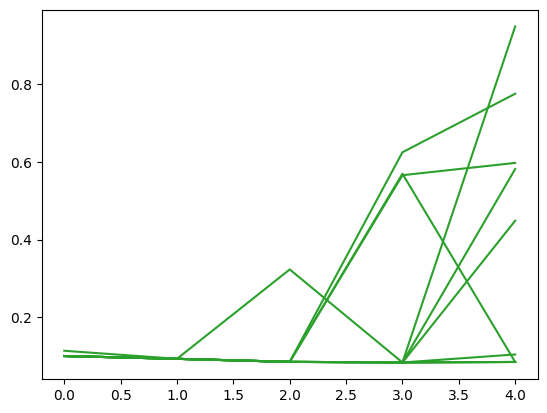

In [24]:
plt.plot(np.stack(results.R4_risk_train), color=cycle[2])
plt.show()

In [ ]:
# n_training_samples = [500, 1000, 2000, 5000, 10000]
n_training_samples = [500, 1000, 2000, 5000]

test_ctx = traj_to_contexts(dataset['test'])
val_ctx = traj_to_contexts(dataset['validation'])

R3_risk = []
R4_risk = []

R3_time = []
R4_time = []

R3_Hdist = []
R4_Hdist = []

R3_eigs = []
R4_eigs = []

R4GT_risk = []
R4GT_eigs = []
R4GT_Hdist = []
R4GT_time = []

for n in n_training_samples:
    print('Training Sample size: ', n)
    # train_traj = resample(dataset['train'], replace=False, n_samples=n, random_state=0)
    train_traj = dataset['train'][:n]
    train_ctx = traj_to_contexts(train_traj)
    
    num_ls = 5
    ls_quantiles = np.linspace(0.05, 0.95, num_ls)
    ls_grid = np.quantile(pdist(train_traj), ls_quantiles)
    reg_grid = np.logspace(-5, 0, 6)
    hp_grid = ParameterGrid({'ls': ls_grid, 'reg': reg_grid})
    
    best_risk, best_vals, best_model, _ = grid_search(hp_grid, 'arnoldi')
    ls = best_vals['ls']
    reg = best_vals['reg']
    kernel = RBF(length_scale=ls)
    
    R3 = KernelDMD(kernel = kernel, rank = configs.rank, tikhonov_reg = reg, svd_solver='arnoldi')
    # R4 = KernelDMD(kernel = kernel, rank = configs.rank, tikhonov_reg = reg, svd_solver='randomized', n_oversamples=20, rng_seed=0)
    
    timed_fit = timer(R3.fit)
    R3, fit_time_R3 = timed_fit(train_ctx)
    R3_risk.append(R3.risk(test_ctx))
    R3_time.append(fit_time_R3)
    eigs = R3.eig()
    top_eigs = topk(np.abs(eigs), 3)
    R3_eigs.append(eigs[top_eigs.indices])
    R3_Hdist.append(directed_hausdorff_distance(R3_eigs[-1], ref_eigs))

    best_risk, best_vals, best_model, _ = grid_search(hp_grid, 'randomized')
    ls = best_vals['ls']
    reg = best_vals['reg']
    kernel = RBF(length_scale=ls)

    risks, eigs, Hdists, timings = R4_repeated_runs(10, False)
    R4_risk.append(risks)
    R4_eigs.append(eigs)
    R4_Hdist.append(Hdists)
    R4_time.append(timings)
    
    risks, eigs, Hdists, timings = R4_repeated_runs(10, True)
    R4GT_risk.append(risks)
    R4GT_eigs.append(eigs)
    R4GT_Hdist.append(Hdists)
    R4GT_time.append(timings)

In [ ]:
dict = {
    'n_training_samples': n_training_samples,
    'R3_risk': R3_risk,
    'R4_risk': R4_risk,
    'R4GT_risk': R4GT_risk,
    'R3_time': R3_time,
    'R4_time': R4_time,
    'R4GT_time': R4GT_time,
    'R3_Hdist': R3_Hdist,
    'R4_Hdist': R4_Hdist,
    'R4GT_Hdist': R4GT_Hdist,
    'R3_eigs': R3_eigs,
    'R4_eigs': R4_eigs,
    'R4GT_eigs': R4GT_eigs,
}

results = pd.DataFrame(dict)
results.to_pickle('results/logistic_map/logistic_map_results_R4HPO.pkl')

In [ ]:
results = pd.read_pickle("results/logistic_map/logistic_map_results_R4HPO.pkl")
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

n = results['n_training_samples']

fig_width = 8.5 #Inches
fig_height = 2.5 #Inches

fig, axes = plt.subplots(ncols=3,figsize=(fig_width, fig_height))

ax = axes[0]
ax.plot(n, results.R3_risk, color=cycle[0])
R4_avg = results.R4_risk.apply(np.min)
R4_std = results.R4_risk.apply(np.std)
ax.plot(n, R4_avg, color=cycle[1])
# ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[1], alpha=0.3)
R4_avg = results.R4GT_risk.apply(np.min)
R4_std = results.R4GT_risk.apply(np.std)
ax.plot(n, R4_avg, color=cycle[2])
# ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[2], alpha=0.3)
ax.set_xlabel('Sample size') 
ax.set_ylabel('Risk') 

ax = axes[1]
ax.plot(n, results.R3_Hdist, color=cycle[0])
R4_avg = results.R4_Hdist.apply(np.min)
R4_std = results.R4_Hdist.apply(np.std)
ax.plot(n, R4_avg, color=cycle[1])
# ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[1], alpha=0.3)
R4_avg = results.R4GT_Hdist.apply(np.min)
R4_std = results.R4GT_Hdist.apply(np.std)
ax.plot(n, R4_avg, color=cycle[2])
# ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[2], alpha=0.3)
ax.set_xlabel('Sample size') 
ax.set_ylabel('Hausdorff distance') 

ax = axes[2]
ax.plot(n, results.R3_time, color=cycle[0], label = 'R3')
R4_avg = results.R4_time.apply(np.median)
R4_std = results.R4_time.apply(np.std)
ax.plot(n, R4_avg, color=cycle[1], label = 'R4')
# ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[1], alpha=0.3)
R4_avg = results.R4GT_time.apply(np.median)
R4_std = results.R4GT_time.apply(np.std)
ax.plot(n, R4_avg, color=cycle[2], label = 'R4 chol')
# ax.fill_between(n, R4_avg + R4_std, R4_avg - R4_std, color=cycle[2], alpha=0.3)
ax.legend()
ax.set_xlabel('Sample size') 
ax.set_ylabel('Execution time [s]') 
ax.set_yscale('log')
ax.set_xscale('log')

plt.tight_layout()
plt.show()
fig.savefig("results/logistic_map/logistic_map_results_R4HPO.pdf",  bbox_inches='tight')


In [ ]:
results.R3_risk